In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks

In [2]:
I = 150e-9
LW_ratio = 8.56

e = 1.6e-19
h = 6.63e-34

gate_voltages = np.linspace(0,-1,5)
depletion_voltages = np.arange(0,1,0.1)

In [3]:
''' some functions useful for plotting stuff '''

def grid():
    plt.grid(which='major',linewidth=0.8)
    plt.grid(which='minor',linestyle=':', linewidth=0.5)
    plt.minorticks_on()

def sub_grid(axs,x,y):

    if x==1 and y==1:
        axs.grid(which='major',linewidth=0.8)
        axs.grid(which='minor',linestyle=':', linewidth=0.5)
        axs.minorticks_on()
    elif x == 1:
        for j in range(y):
            axs[j].grid(which='major',linewidth=0.8)
            axs[j].grid(which='minor',linestyle=':', linewidth=0.5)
            axs[j].minorticks_on()
    elif y == 1:
        for i in range(x):
            axs[i].grid(which='major',linewidth=0.8)
            axs[i].grid(which='minor',linestyle=':', linewidth=0.5)
            axs[i].minorticks_on()
    else:
        for i in range(x):
            for j in range(y):
                axs[i,j].grid(which='major',linewidth=0.8)
                axs[i,j].grid(which='minor',linestyle=':', linewidth=0.5)
                axs[i,j].minorticks_on()


def autoscale_y(ax,margin=0.1):
    """This function rescales the y-axis based on the data that is visible given the current xlim of the axis.
    ax -- a matplotlib axes object
    margin -- the fraction of the total height of the y-data to pad the upper and lower ylims"""

    def get_bottom_top(line):
        xd = line.get_xdata()
        yd = line.get_ydata()
        lo,hi = ax.get_xlim()
        y_displayed = yd[((xd>lo) & (xd<hi))]
        h = np.max(y_displayed) - np.min(y_displayed)
        bot = np.min(y_displayed)-margin*h
        top = np.max(y_displayed)+margin*h
        return bot,top

    lines = ax.get_lines()
    bot,top = np.inf, -np.inf

    for line in lines:
        new_bot, new_top = get_bottom_top(line)
        if new_bot < bot: bot = new_bot
        if new_top > top: top = new_top

    ax.set_ylim(bot,top)

In [4]:
''' other useful functions '''

def fourier(x,y,start,stop):
    ''' function for fourier transforming data periodic in 1/B. Data points need to be evenly spaced so uses a spline interpolation before fourier transforming.'''
    x_trunc = np.array(x[start:stop])
    y_trunc = np.array(y[start:stop])

    x_new = np.arange(np.min(x_trunc),np.max(x_trunc),0.025)

    y_new = np.interp(x_new,x_trunc[::-1],y_trunc[::-1])
    xf = rfftfreq(len(x_new))
    yf = rfft(y_new)

    return xf,yf



def locate(data, point):
    ''' find the row at which the B field is some specific value. Uses rounding so isnt very precise.'''

    dp = -int(np.floor(np.log10(abs(point)))) + 1


    for i in range(len(data['B'])):
        if np.round(data['B'][i], dp) == point:
            return i

In [5]:
def load_data(gate_voltage,coil=True, direction='up'):

    if coil == True:            # data with the coil and without the coil are saved in different folders with different folder names for each set of data
        path = '/Users/Bryn_Lloyd/Documents/Uni/LCN/Final Data/Enhancement Coil/'
        folders = []
        gate_voltages = np.linspace(0,-1,5)
        for i,j in enumerate(gate_voltages):
            folders.append(f'23-07-28_coil_enhancement_{i+1}_{j}V')
    
    else:
        path = '/Users/Bryn_Lloyd/Documents/Uni/LCN/Final Data/Enhancement No Coil/'

        folders = []
        gate_voltages = np.linspace(0,-1,5)
        for i,j in enumerate(gate_voltages):
            folders.append(f'23-07-28_no-coil_enhancement_{i+1}_{j}V')
        
    files = [f'B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_{i}' for i in ['up','down']]

    filename = folders[-int(gate_voltage*4)] + '/' + (files[0] if direction == 'up' else files[1])
    print(filename)

    data = pd.read_csv(f'{path}{filename}.txt', sep = '\s+', header=0)
    data = data.rename(columns={'B(T)': 'B',
                                'Vxx_x(V)':'Vxx_IP',
                                'Vxx_y(V)':'Vxx_OOP',
                                'Vxy_x(V)':'Vxy_IP',
                                'Vxy_y(V)':'Vxy_OOP'})

    for column in data.columns:        # Vxy measured the wrong direction so the sign needs to be flipped for every Vxy measurement
        if 'Vxy' in column:
            data[column] *= -1

    def point_average_data(x_data, y_data):        # B field can have non-unique values if the field is swept too slowly so this fixes them
        df = pd.DataFrame(list(zip(list(x_data), list(y_data))), columns=['x','y'])
        df_point_average = df.groupby('x').mean().reset_index()
        return np.array(df_point_average['x']),  np.array(df_point_average['y'])

    data2 = pd.DataFrame()       # to remove non-unique values of B
    data2['B'], data2['Vxx_IP'] = point_average_data(data['B'].tolist(), data['Vxx_IP'].tolist())
    _, data2['Vxx_OOP'] = point_average_data(data['B'].tolist(), data['Vxx_OOP'].tolist())
    _, data2['Vxy_IP'] = point_average_data(data['B'].tolist(), data['Vxy_IP'].tolist())
    _, data2['Vxy_OOP'] = point_average_data(data['B'].tolist(), data['Vxy_OOP'].tolist())
    
    data2['B-1'] = 1/data2['B']

    data2['Rxx_IP'] = data2['Vxx_IP'] / (I * LW_ratio)
    data2['Rxx_OOP'] = data2['Vxx_OOP'] / (I * LW_ratio)

    data2['Rxy_IP'] = data2['Vxy_IP'] / I
    data2['Rxy_OOP'] = data2['Vxy_OOP'] / I

    return data2

def load_depletion(gate_voltage, direction='up'):
    ''' for loading depletion data. There is no 'no coil' data so its easier to just write another function '''

    path = '/Users/Bryn_Lloyd/Documents/Uni/LCN/Final Data/Depletion Coil/'
    folders=[]
    for i,j in enumerate(depletion_voltages):
        folders.append(f'23-07-28_{i+1}_{round(j,1)}V')

    files = [f'B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_{i}' for i in ['up','down']]

    filename = folders[int(gate_voltage*10)] + '/' + (files[0] if direction == 'up' else files[1])
    print(filename)

    data = pd.read_csv(f'{path}{filename}.txt', sep = '\s+', header=0)
    data = data.rename(columns={'B(T)': 'B',
                                'Vxx_x(V)':'Vxx_IP',
                                'Vxx_y(V)':'Vxx_OOP',
                                'Vxy_x(V)':'Vxy_IP',
                                'Vxy_y(V)':'Vxy_OOP'})

    for column in data.columns:        # Vxy measured the wrong direction so the sign needs to be flipped for every Vxy measurement
        if 'Vxy' in column:
            data[column] *= -1

    def point_average_data(x_data, y_data):        # B field can have non-unique values if the field is swept too slowly so this fixes them
        df = pd.DataFrame(list(zip(list(x_data), list(y_data))), columns=['x','y'])
        df_point_average = df.groupby('x').mean().reset_index()
        return np.array(df_point_average['x']),  np.array(df_point_average['y'])

    data2 = pd.DataFrame()       # to remove non-unique values of B
    data2['B'], data2['Vxx_IP'] = point_average_data(data['B'].tolist(), data['Vxx_IP'].tolist())
    _, data2['Vxx_OOP'] = point_average_data(data['B'].tolist(), data['Vxx_OOP'].tolist())
    _, data2['Vxy_IP'] = point_average_data(data['B'].tolist(), data['Vxy_IP'].tolist())
    _, data2['Vxy_OOP'] = point_average_data(data['B'].tolist(), data['Vxy_OOP'].tolist())
    
    data2['B-1'] = 1/data2['B']

    data2['Rxx_IP'] = data2['Vxx_IP'] / (I * LW_ratio)
    data2['Rxx_OOP'] = data2['Vxx_OOP'] / (I * LW_ratio)

    data2['Rxy_IP'] = data2['Vxy_IP'] / I
    data2['Rxy_OOP'] = data2['Vxy_OOP'] / I

    return data2

In [6]:
''' Functions for plotting data:
view_data(V_g) makes plots for each file
compare_data() makes the same plot for every file'''


def view_data(V_g,coil=True,direction='up'):
    data = load_data(V_g,coil=coil,direction=direction)
    plt.rcParams['figure.figsize'] = [10, 10]

    fig,axs = plt.subplots(4,2)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for i in range(4):
        for j in range(2):
            axs[i,j].grid(which='major',linewidth=0.8)
            axs[i,j].grid(which='minor',linestyle=':', linewidth=0.5)
            axs[i,j].minorticks_on()

    fig.suptitle(f'''Gate Voltage = {abs(V_g)} V
    <-- In Phase | Out of Phase -->''')

    axs[0,0].set_title(r'$\frac{dR_{xx}}{dB}$')
    axs[1,0].set_title(r'$\frac{dR_{xy}}{dB}$')
    axs[2,0].set_title(r'$\frac{dR_{xy}}{dB}$ Low-Field')

    axs[0,1].set_title(r'$\frac{dR_{xx}}{dB}$')
    axs[1,1].set_title(r'$\frac{dR_{xy}}{dB}$')
    axs[2,1].set_title(r'$\frac{dR_{xy}}{dB}$ Low-Field')


    axs[0,0].plot(data['B'],data['Rxx_IP'])
    axs[1,0].plot(data['B'],data['Rxy_IP'])
    axs[2,0].plot(data['B'],data['Rxy_IP'])
    axs[2,0].axvspan(-0.1,0.1,facecolor='0.1',alpha=0.1)
    axs[2,0].axvspan(0.3,2,facecolor='0.1',alpha=0.1)
    axs[2,0].axvspan(-0.3,-2,facecolor='0.1',alpha=0.1)
    axs[2,0].set_xlim([0,0.5])
    autoscale_y(axs[2,0])

    axs[0,1].plot(data['B'],data['Rxx_OOP'])
    axs[1,1].plot(data['B'],data['Rxy_OOP'])

    axs[2,1].plot(data['B'],data['Rxy_OOP'])
    axs[2,1].axvspan(-0.1,0.1,facecolor='0.1',alpha=0.1)
    axs[2,1].axvspan(0.3,2,facecolor='0.1',alpha=0.1)
    axs[2,1].axvspan(-0.3,-2,facecolor='0.1',alpha=0.1)
    axs[2,1].set_xlim([0,0.5])
    autoscale_y(axs[2,1])


    axs[3,0].set_title(r'$\frac{dR_{xy}}{dB}$ Zero-Region')
    axs[3,0].plot(data['B'],data['Rxy_IP'])
    axs[3,0].set_xlim([-0.2,0.2])
    autoscale_y(axs[3,0])

    axs[3,1].set_title(r'$\frac{dR_{xy}}{dB}$ Zero-Region')
    axs[3,1].plot(data['B'],data['Rxy_OOP'])
    axs[3,1].set_xlim([-0.2,0.2])
    autoscale_y(axs[3,1])
    plt.show()



def compare_data(column = 'Rxy_IP',coil=True,direction='up'):
    fig,axs = plt.subplots(len(gate_voltages),3)
    fig.subplots_adjust(hspace=0.4, wspace=0.3,top=0.95)

    for i in range(len(gate_voltages)):
        for j in range(3):
            axs[i,j].grid(which='major',linewidth=0.8)
            axs[i,j].grid(which='minor',linestyle=':', linewidth=0.5)
            axs[i,j].minorticks_on()

    for i, V_g in enumerate(gate_voltages):
        data = load_data(V_g,coil=coil,direction=direction)

        plt.suptitle(f'{column} for each gate voltage')

        axs[i,0].set_ylabel(f'{abs(V_g)} V')
        axs[i,0].plot(data['B'],data[column])
        
        axs[i,1].plot(data['B'],data[column])
        axs[i,1].axvspan(-0.1,0.1,facecolor='0.1',alpha=0.1)
        axs[i,1].axvspan(0.3,2,facecolor='0.1',alpha=0.1)
        axs[i,1].axvspan(-0.3,-2,facecolor='0.1',alpha=0.1)
        axs[i,1].set_xlim([0,0.5])
        autoscale_y(axs[i,1])

        axs[i,2].plot(data['B'],data[column])
        axs[i,2].set_xlim([-0.2,0.2])
        autoscale_y(axs[i,2])
    plt.show()

23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down


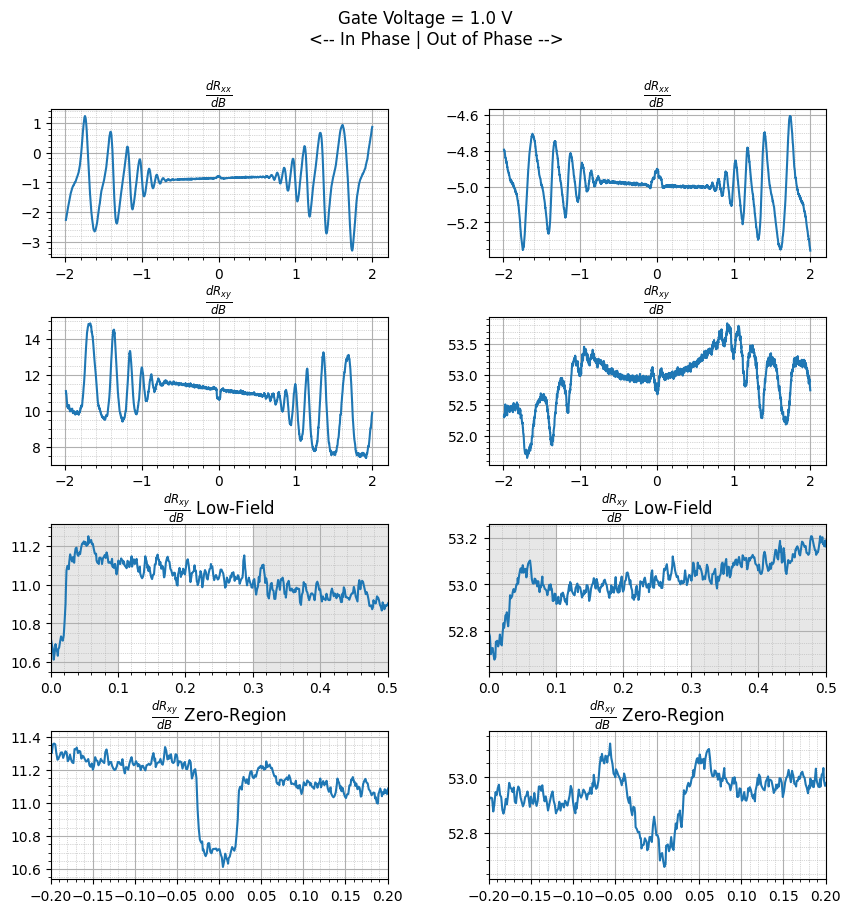

In [7]:
view_data(-1.0, coil=True, direction='down')

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down


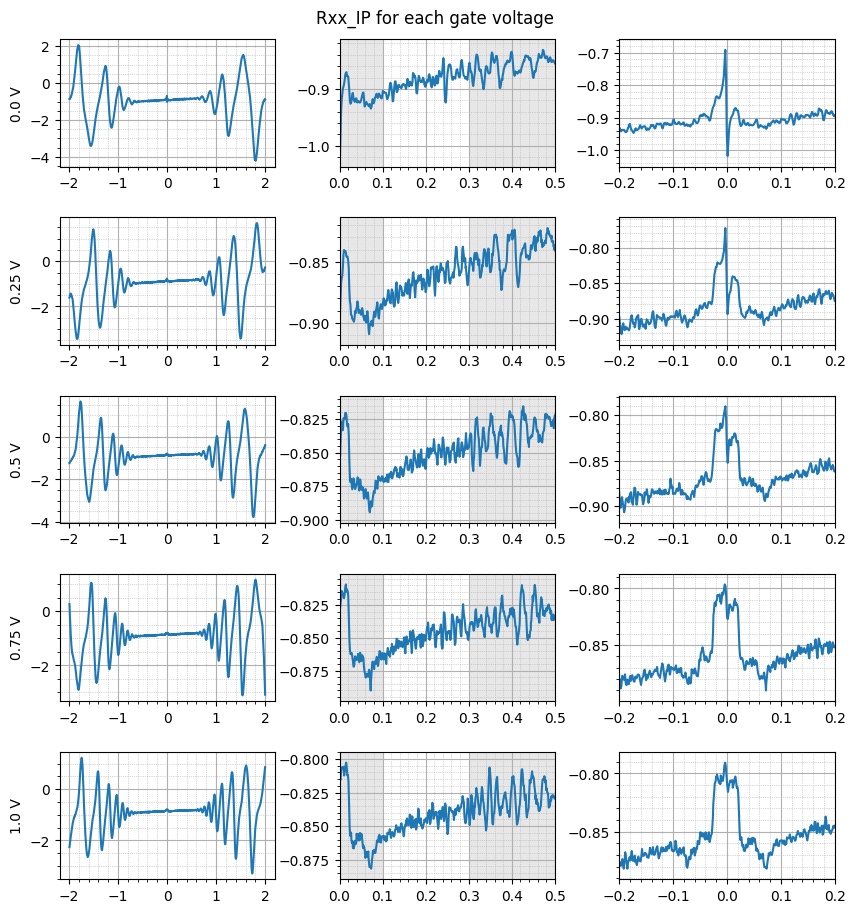

In [8]:
compare_data('Rxx_IP',direction='down')

## Things to do:

1. try and fit to the different plateaus
2. is the step from each side up to the plateau the same?
3. does the height of the asymmetry change (the asymptotic bit)

4. find carrier densities using the no-coil data
5. find carrier densities by measuring the period of the SdH oscillations


## Things that change with carrier density:
### Rxx In Phase
- size of the vertical 'asymptote'
- height of the plateau at +ve B (Height at -ve B appears to stay roughly consant)

### Rxx Out of Phase
- only difference is the size of the 'asymptote'

### Rxy In Phase
- Height of data outside of the zero region
- Accounting for ^ , the depth of the 'well' at zero stays roughly the same depth

### Rxy Out of Phase
- very similar to In Phase


### Rxx In Phase

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


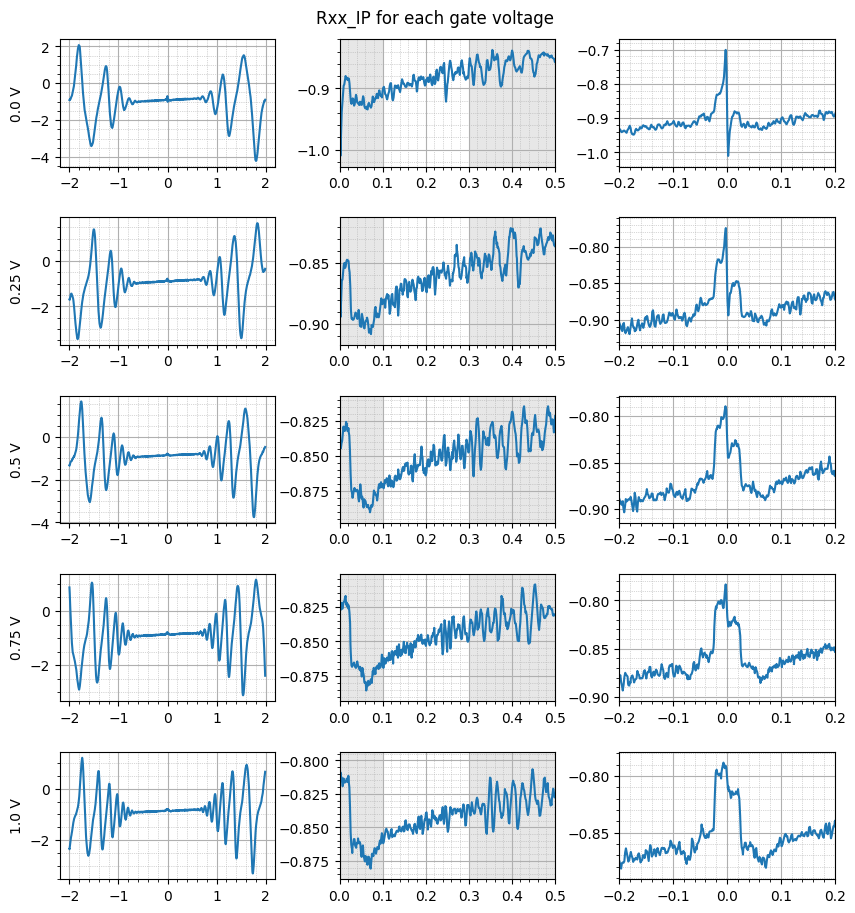

In [9]:
compare_data('Rxx_IP')

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


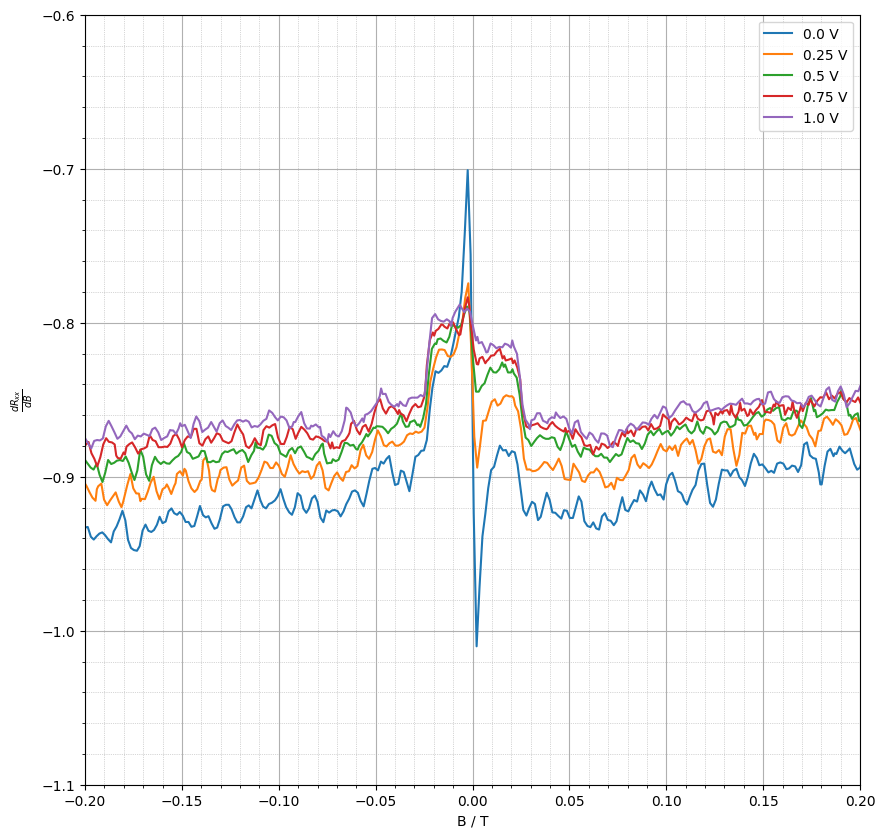

In [10]:
# fig,axs = plt.subplots(len(gate_voltages))
# for i,V_g in enumerate(gate_voltages):
#     data = load_data(V_g)
#     axs[i].plot(data['B'],data['Rxx_IP'])
#     axs[i].set_xlim([-0.2,0.2])
#     autoscale_y(axs[i])
# sub_grid(axs,5,1)
# plt.show()


for i,V_g in enumerate(gate_voltages):
    data = load_data(V_g)
    plt.plot(data['B'],data['Rxx_IP'],label=f'{abs(V_g)} V')
    plt.xlim([-0.2,0.2])
    plt.ylim([-1.1,-0.6])
grid()
plt.legend()
plt.xlabel('B / T')
plt.ylabel(r'$\frac{dR_{xx}}{dB}$')
plt.show()

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


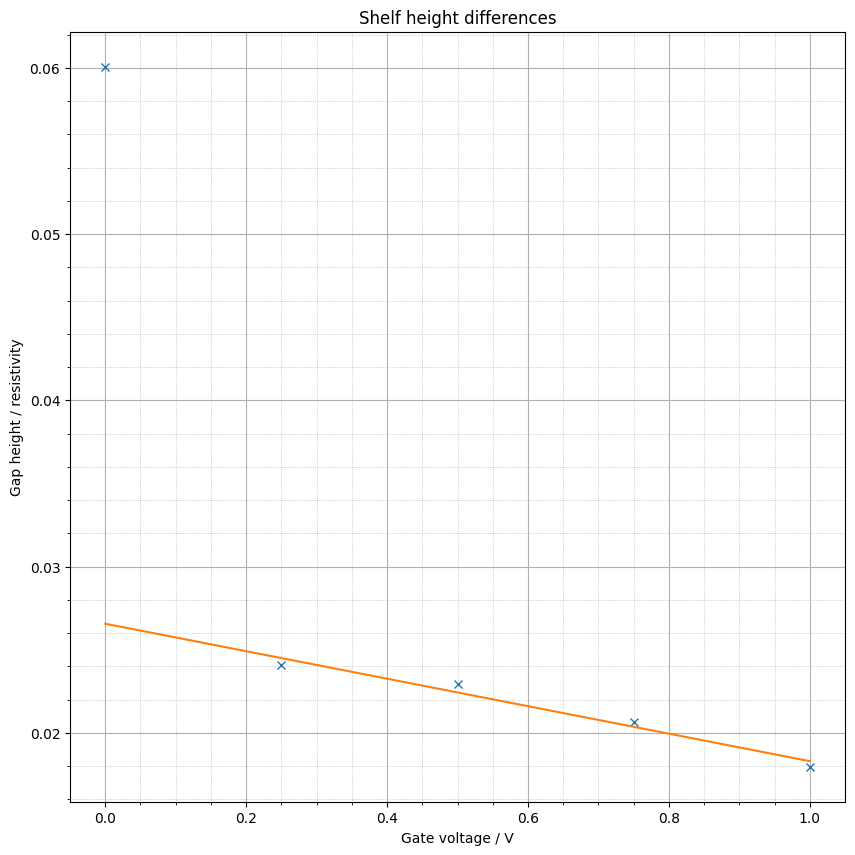

In [11]:
def shelf_heights(output=False):
    ''' measures the height of the 'shelves' and the difference in the heights in the zero region of Rxx_IP'''
    gap = []
    for V_g in gate_voltages:
        data = load_data(V_g,coil=True)


        shelf_edge = [-0.02,-0.01,0.01,0.02]
        shelf_pos = np.zeros(4)

        for i,edge in enumerate(shelf_edge):
            for j in range(len(data['B'])):
                if round(data['B'][j]+0.005,2) == edge:
                    shelf_pos[i] = j

        fit_neg = np.polyfit(data['B'][shelf_pos[:2]],data['Rxx_IP'][shelf_pos[:2]],1)
        pfit_neg = np.poly1d(fit_neg)
        mid_point_neg = pfit_neg(shelf_edge[0] + (shelf_edge[1] - shelf_edge[0])/2)

        fit_pos = np.polyfit(data['B'][shelf_pos[2:]],data['Rxx_IP'][shelf_pos[2:]],1)
        pfit_pos = np.poly1d(fit_pos)
        mid_point_pos = pfit_pos(shelf_edge[2] + (shelf_edge[3] - shelf_edge[2])/2)
        gap.append(mid_point_neg - mid_point_pos)

        if output == True:
            fig,ax = plt.subplots()
            ax.set_title(f'Gate Voltage = {abs(V_g)} V')
            ax.set_ylabel(r'$\frac{dR_{xx}}{dB}$')
            ax.set_xlabel('B / T')
            ax.plot(data['B'],data['Rxx_IP'])
            ax.set_xlim([-0.2,0.2])
            autoscale_y(ax)
            grid()

            plt.plot([-0.04,0], [mid_point_neg,mid_point_neg],color='C1')
            plt.plot([0,0.04], [mid_point_pos,mid_point_pos],color='C1')
            plt.show()


    return gap

gap = shelf_heights()
plt.title('Shelf height differences')
plt.xlabel('Gate voltage / V')    # should be replaced with carrier density
plt.ylabel('Gap height / resistivity')
plt.plot(abs(gate_voltages), gap,'x')
pfit = np.poly1d(np.polyfit(abs(gate_voltages[1:]),gap[1:],1))
plt.plot([0,1],pfit([0,1]))

grid()
plt.show()


### Rxy In Phase

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


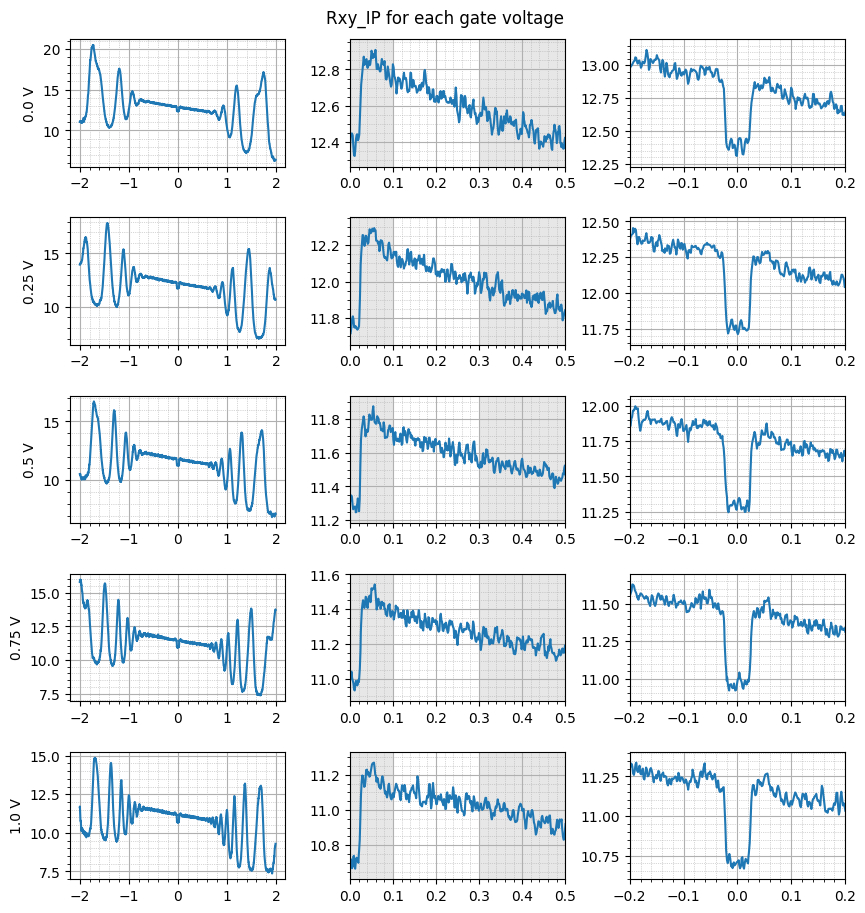

In [12]:
compare_data('Rxy_IP')

In [13]:
def well_depth(data,output=False):
    start1 = locate(data, -0.5)
    stop1 = locate(data, -0.1)
    start2 = locate(data, 0.1)
    stop2 = locate(data, 0.5)

    fit1 = np.polyfit(data['B'][start1:stop1],data['Rxy_IP'][start1:stop1],1)
    fit2 = np.polyfit(data['B'][start2:stop2],data['Rxy_IP'][start2:stop2],1)

    fit = [np.mean([fit1[i], fit2[i]]) for i in range(2)]
    pfit = np.poly1d(fit)

    pfit1 = np.poly1d(fit1)
    pfit2 = np.poly1d(fit2)


    for i in range(len(data['B'])):
        if round(data['B'][i],2) == -0.02:
            well_start = i
        if round(data['B'][i],2) == 0.01:
            well_stop = i

    well_fit = np.polyfit(data['B'][well_start:well_stop], data['Rxy_IP'][well_start:well_stop],1)
    well_pfit = np.poly1d(well_fit)

    if output == True:
        # fig,axs = plt.subplots(2)
        # axs[0].plot(data['B'], data['Rxy_IP'])
        # axs[0].plot([-0.5,0.5],pfit2([-0.5,0.5]))
        # axs[0].plot([-0.1,0.1],well_pfit([-0.1,0.1]),color='C1')
        # axs[0].set_xlim([-1,1])

        # axs[1].plot(data['B'], data['Rxy_IP'])
        # axs[1].plot([-0.5,0.5],pfit2([-0.5,0.5]))
        # axs[1].set_xlim([-0.1,0.1])
        # # axs[1].plot(data['B'][well_start],data['Rxy_IP'][well_start],'o',color='k')
        # # axs[1].plot(data['B'][well_stop],data['Rxy_IP'][well_stop],'o',color='k')
        # axs[1].plot([-0.1,0.1],well_pfit([-0.1,0.1]))
        # sub_grid(axs,2,1)
        # # autoscale_y(axs[1])   # for some reason function foesnt work this time
        # axs[1].set_ylim([10,15])
        # plt.show()

        fig,ax = plt.subplots()
        ax.plot(data['B'], data['Rxy_IP'])
        ax.plot([-0.5,0.5],pfit2([-0.5,0.5]))
        ax.set_xlim([-0.1,0.1])
        ax.plot([-0.1,0.1],well_pfit([-0.1,0.1]))
        grid()
        ax.set_title(f'Gate Voltage = {abs(V_g)}')
        ax.set_ylim([10,15])
        ax.set_xlabel('B / T')
        ax.set_ylabel(r'$\frac{dR_{xy}}{dB}$')
        # autoscale_y(ax)
        plt.show()    



    depth = []
    for x in [data['B'][well_start], 0, data['B'][well_stop]]:
        y_top = pfit2(x)
        y_bottom = well_pfit(x)

        depth.append(y_top - y_bottom)
    depth = depth[1] 
    return depth

In [14]:
# well_depth(load_data(-0.75),output=True)


depths = []
for V_g in gate_voltages:
    depths.append(well_depth(load_data(V_g), output=False))     # last 2 are very slanted so the fit parameters need to be adjusted slightly - may just be because of the noise in the region

depths

23-07-28_coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


[0.4592673654340551,
 0.4508743123487928,
 0.477135273479945,
 0.4649901030798631,
 0.4735516593575131]

Text(0, 0.5, 'Depth of the well / resistivity units')

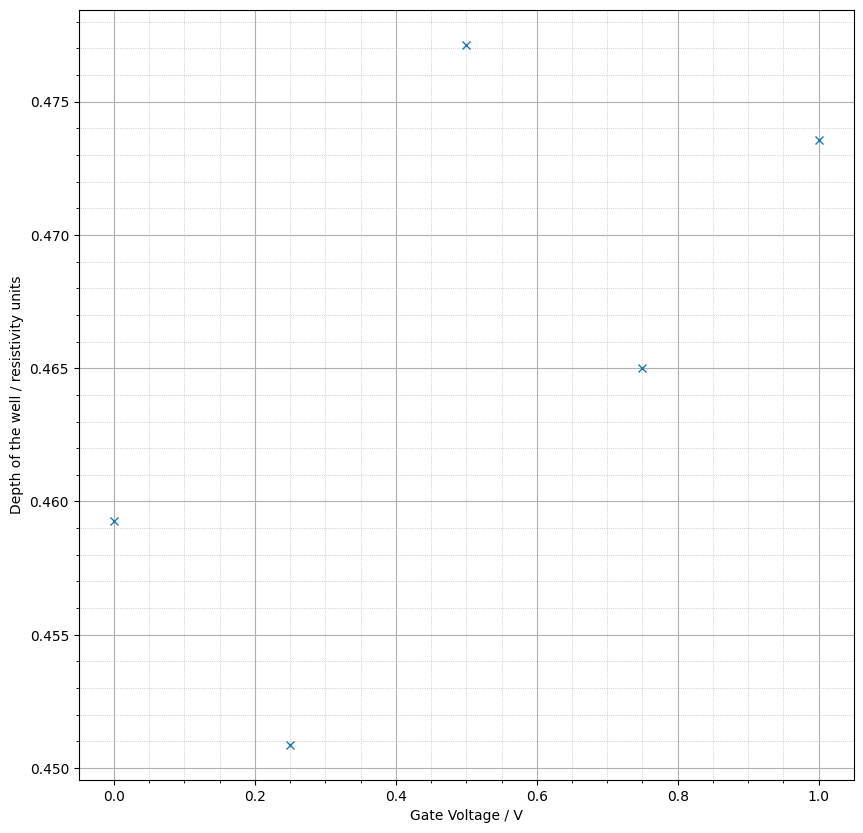

In [15]:
plt.plot(abs(gate_voltages),depths,'x')
grid()
plt.xlabel('Gate Voltage / V')
plt.ylabel('Depth of the well / resistivity units')

### Calculating Carrier Densities for each gate voltage

In [16]:
''' no coil data can be loaded using the load_data function with kwarg coil=False'''


def carrier_density_hall(output=False):
    carrier_densities = []
    for V_g in gate_voltages:
        nc_data = load_data(V_g, coil=False)

        B_lim = 0.7
        start = locate(nc_data, -B_lim)
        stop = locate(nc_data, B_lim)
        fit = np.polyfit(nc_data['B'][start:stop], nc_data['Rxy_IP'][start:stop], 1)

        carrier_densities.append(1/(fit[0]*e))

        if output == True:
            pfit = np.poly1d(fit)
            plt.plot(nc_data['B'], nc_data['Rxy_IP'])
            plt.plot([-2,2], pfit([-2,2]))
            grid()
            plt.show()

    return carrier_densities



def carrier_density_SdH(enhancement=True, output=False):

    if enhancement == True:
        voltages = gate_voltages

    else:
        voltages = depletion_voltages

    if output == True:  # creates the figure with subplots title/axis labels
        plt.rcParams['figure.figsize'] = [10, 15]
        fig,axs = plt.subplots(len(voltages),3)
        sub_grid(axs,len(voltages),3)
        axs[0,0].set_title('''SdH oscillations in B
        (red used in FFT)''')
        axs[0,1].set_title('SdH oscillations in 1/B')
        axs[0,2].set_title('''FFT's''')

        axs[4,0].set_xlabel('B')
        axs[4,1].set_xlabel('1/B')
        axs[4,2].set_xlabel('B')

    start,stop = [1600,9904]
    peak_freqs = []

    for i, V_g in enumerate(voltages):
        if enhancement == True:
            data = load_data(V_g,coil=False, direction='up')
        else:
            data = load_depletion(V_g, direction='up')

        xf,yf = fourier(data['B-1'], data['Rxx_IP'],start,stop)
        xf = xf[1:]
        yf = yf[1:]
        peaks = find_peaks(abs(yf))[0]
        peak_heights = yf[peaks]
        
        max_peak_height = 0
        max_peak_pos = 0
        x = zip(peaks, peak_heights)
        for element in x:
            if abs(element[1]) > max_peak_height:
                max_peak_height = abs(element[1])
                max_peak_pos = element[0]
        peak_freqs.append(xf[max_peak_pos])

        if output == True:
            axs[i,0].plot(data['B'], data['Rxx_IP'],label=f'{-V_g} V',linewidth=5)
            axs[i,0].plot(data['B'][start:stop], data['Rxx_IP'][start:stop],color='red',label=f'{-V_g} V')
            axs[i,0].set_xlim([0,2])
            if enhancement==True:
                axs[i,0].set_ylabel(f'{abs(V_g)} V')
            else:
                axs[i,0].set_ylabel(f'{-round(V_g,1)} V')
            axs[i,1].plot(data['B-1'][1600:], data['Rxx_IP'][1600:],label=f'{-V_g} V',linewidth=5)
            axs[i,1].plot(data['B-1'][start:stop], data['Rxx_IP'][start:stop],color='red',label=f'{-V_g} V')
            axs[i,1].set_xlim([0.2,2])
            axs[i,2].plot(xf,abs(yf))
            axs[i,2].plot(xf[max_peak_pos],abs(yf[max_peak_pos]),'x',color='red', label=f'Freq = {round(xf[max_peak_pos],2)} T')
            axs[i,2].legend()
            axs[i,2].set_xlim([0,0.5])

    carrier_densities = 2 * e * np.array(peak_freqs) / h    
    return carrier_densities

23-07-28_no-coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up


array([5.27491366e+13, 6.03318250e+13, 7.16813763e+13, 7.85179733e+13,
       8.97962047e+13])

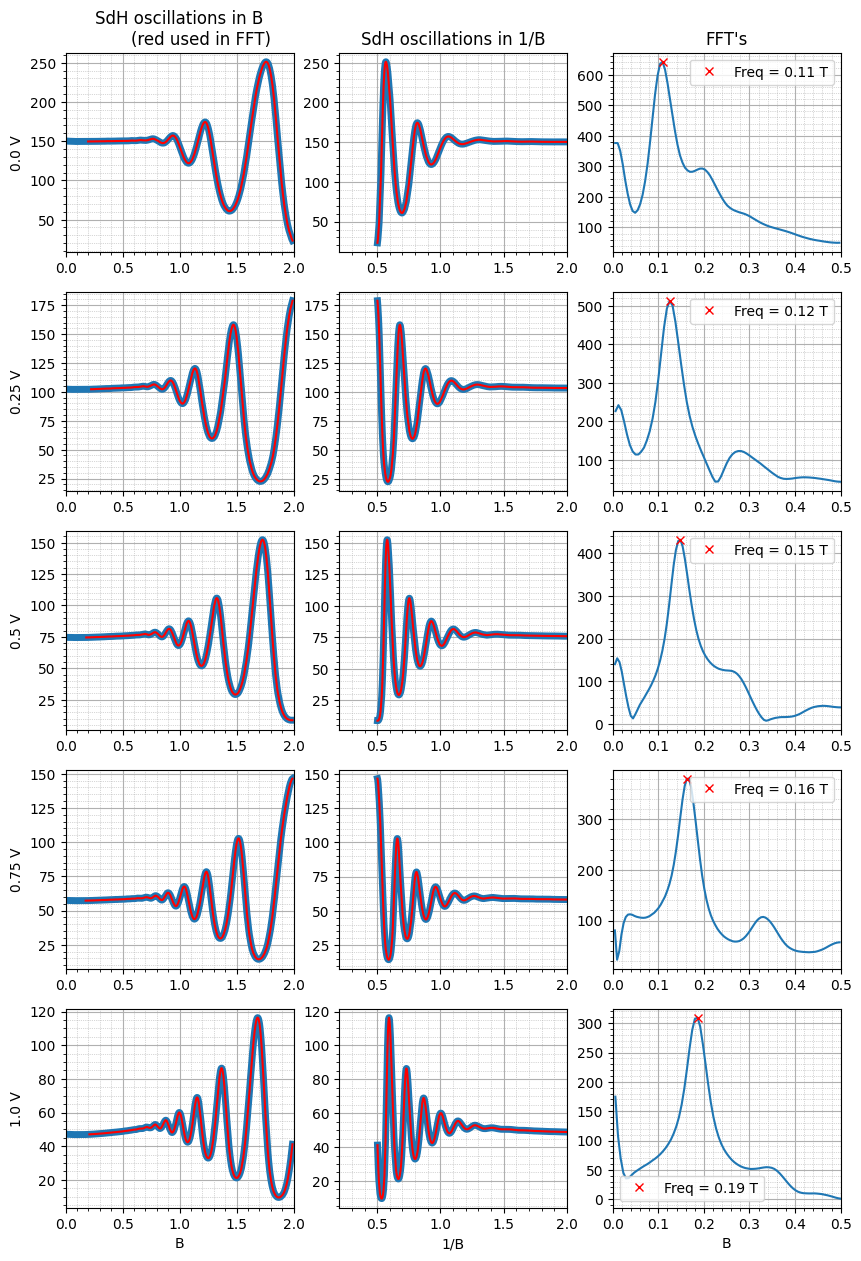

In [31]:
carrier_density_SdH(enhancement=True, output=True)

23-07-28_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_2_0.1V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_3_0.2V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_4_0.3V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_5_0.4V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_6_0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_7_0.6V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_8_0.7V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_9_0.8V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_10_0.9V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y

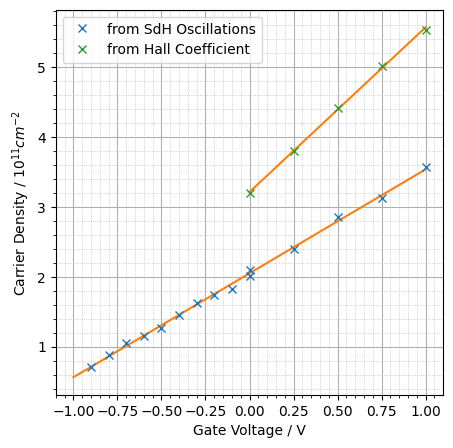

In [19]:
plt.rcParams['figure.figsize'] = [5, 5]


# 39.7853985140625 is the ratio between measured period of oscillations and that calculated from the fft
# *1e-4 to convert to cm^-2
# *1e-11 so that the exponent can be given in the axis label as it looks neater
n1 = carrier_density_SdH(enhancement=False) * 39.7853985140625 * 1e-4 * 1e-11
n2 = carrier_density_SdH(enhancement=True) * 39.7853985140625 * 1e-4 * 1e-11
n = np.append(n1,n2)

V = np.append((-depletion_voltages),(-gate_voltages))
pfit = np.poly1d(np.polyfit(V,n,1))
plt.plot([-1,1], pfit([-1,1]),color='C1')
plt.plot(V, n, 'x',color='C0', label='from SdH Oscillations')

grid()


plt.xlabel('Gate Voltage / V')
plt.ylabel(r'Carrier Density / $10^{11} cm^{-2}$')

measured_n = np.array([2.01106e15,2.45939e15,2.75934e15,3.29083e15,3.55874e15])


n_hall = np.array(carrier_density_hall()) * 1e-4 * 1e-11

pfit2 = np.poly1d(np.polyfit(-gate_voltages,n_hall,1))
plt.plot([0,1], pfit2([0,1]), color='C1')
plt.plot(-gate_voltages, n_hall,'x',color='C2',label='from Hall Coefficient')


plt.legend()
# plt.savefig('/Users/Bryn_Lloyd/Documents/Uni/LCN/carrier_density.jpg',dpi=300)
plt.show()



23-07-28_no-coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_1_0.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_no-coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_2_-0.25V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_no-coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_3_-0.5V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_no-coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_4_-0.75V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down
23-07-28_no-coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_up
23-07-28_no-coil_enhancement_5_-1.0V/B(T)_Vxx_x(V)_Vxx_y(V)_Vxy_x(V)_Vxy_y(V)_down


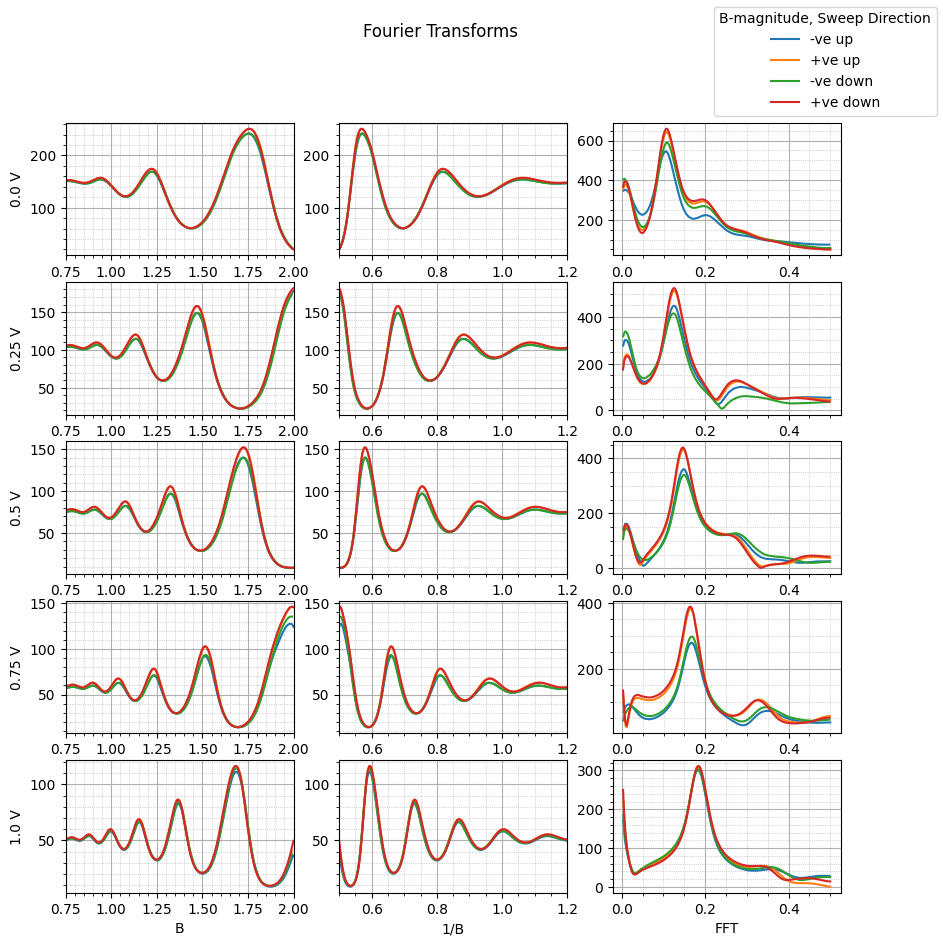

In [64]:
plt.rcParams['figure.figsize'] = [10, 10]

fig,axs = plt.subplots(len(gate_voltages), 3)
for i, V_g in enumerate(gate_voltages):
    for direction in ['up', 'down']:
        data = load_data(V_g, coil=False, direction=direction)

        start1 = 0
        stop1 = int( len(data)/2 -100)
        start2 = int( len(data)/2 +100)
        stop2 = len(data)

        xf1,yf1 = fourier(data['B-1'], data['Rxx_IP'],start1,stop1)
        xf1 = xf1[1:]
        yf1 = yf1[1:]
        xf2,yf2 = fourier(data['B-1'], data['Rxx_IP'],start2,stop2)
        xf2 = xf2[1:]
        yf2 = yf2[1:]



        axs[i,0].set_ylabel(f'{abs(V_g)} V')
        axs[len(gate_voltages)-1,0].set_xlabel('B')
        axs[len(gate_voltages)-1,1].set_xlabel('1/B')
        axs[len(gate_voltages)-1,2].set_xlabel('FFT')
        

        axs[i,0].plot(-data['B'][start1:stop1],data['Rxx_IP'][start1:stop1])
        axs[i,0].plot(data['B'][start2:stop2],data['Rxx_IP'][start2:stop2])
        axs[i,0].set_xlim([0.75,2])

        axs[i,1].plot(-data['B-1'][start1:stop1],data['Rxx_IP'][start1:stop1])
        axs[i,1].plot(data['B-1'][start2:stop2],data['Rxx_IP'][start2:stop2])
        axs[i,1].set_xlim([0.5,1.2])


        axs[i,2].plot(xf1, abs(yf1))
        axs[i,2].plot(xf2, abs(yf2))


sub_grid(axs, len(gate_voltages), 3)
fig.suptitle('Fourier Transforms')
fig.legend(['-ve up','+ve up','-ve down','+ve down'], title='B-magnitude, Sweep Direction')
plt.show()